In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import daft

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


## Coffee Ratings

[The coffee ratings dataset](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-07-07) contains over 1300 thousand coffee reviews from the Coffee Quality Institute. 

The description of the variables in this dataset is available [here](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-07-07). You can also check the [coffee review website](https://www.coffeereview.com/interpret-coffee/) for the meaning of the dimensions they use for review (e.g. aroma, aftertaste etc.).

In this assignment, we will analyze a simplified version of this dataset by using `aroma` ($AR$), `aftertaste` ($AT$), `species` ($SP$) and  `total_cup_points` ($CP$) from this dataset. 



In [3]:
d = pd.read_csv("coffee_ratings.csv")

dsimp = d[["farm_name", "total_cup_points", "aroma", "aftertaste", "species"]].groupby(by='farm_name').sample(n = 1)

dsimp.head()

,farm_name,total_cup_points,aroma,aftertaste,species
255,-,84.00,7.67,7.67,Arabica
1269,1,76.17,7.33,6.50,Arabica
1307,200 farms,67.92,6.75,6.42,Arabica
1297,2000 farmers,72.33,6.92,7.08,Arabica
1047,2000 farms,80.75,7.42,7.42,Arabica


## Part 1 - Coffee Quality 

Suppose we assume the following DAG in which $AR$ is `aroma`, $AT$ `aftertaste`, $SP$ `species`  and $CP$  `total_cup_points`.


<Axes:>

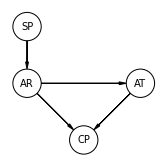

In [4]:
pgm = daft.PGM()
pgm.add_node("SP","SP",0,2)
pgm.add_node("AR","AR",0,1)
pgm.add_node("AT","AT",2,1)
pgm.add_node("CP","CP",1,0)
pgm.add_edge("SP", "AR")
pgm.add_edge("AR", "AT")
pgm.add_edge("AT", "CP")
pgm.add_edge("AR", "CP")
pgm.render()

> Note: for all the steps below, do not forget to re-scale your variables considering what they represent, and choose suitable priors. 

Use backdoor criterion and estimate the **total** effect of $SP$ on $CP$. 

In [43]:
#First,standardize the data
dsimp["ar"]=(dsimp.aroma-dsimp.aroma.mean()) / dsimp.aroma.std()
dsimp["at"]=(dsimp.aftertaste - dsimp.aftertaste.mean()) / dsimp.aftertaste.std()
dsimp["cp"]=(dsimp.total_cup_points-dsimp.total_cup_points.mean())/dsimp.total_cup_points.std()
#Create a column sp and change species into dummy variables
dsimp["sp"]=dsimp['species']
dsimp['sp'] = pd.factorize(dsimp['sp'])[0]
dsimp.head()







,farm_name,total_cup_points,aroma,aftertaste,species,ar,at,cp,sp
255,-,84.00,7.67,7.67,Arabica,0.267075,0.778865,0.675982,0
1269,1,76.17,7.33,6.50,Arabica,-0.789578,-2.568209,-2.122258,0
1307,200 farms,67.92,6.75,6.42,Arabica,-2.592103,-2.797069,-5.070595,0
1297,2000 farmers,72.33,6.92,7.08,Arabica,-2.063777,-0.908976,-3.494575,0
1047,2000 farms,80.75,7.42,7.42,Arabica,-0.509876,0.063678,-0.485484,0


$$
\begin{align*} CP_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha_{sp[i]}
\\
\alpha_j &\sim \text{Normal}(0, 0.5)
\\
\sigma &\sim \text{Exponential}(1) \end{align*}$$

In [6]:
with pm.Model() as model_sp:
    alpha = pm.Normal('alpha', mu = 0, sigma = 0.5, shape = 2)
    sigma = pm.Exponential('sigma',1)
    mu = alpha[dsimp.sp]
    cp = pm.Normal('CP', mu = mu, sigma = sigma, observed = dsimp.cp)
    trace_sp = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [7]:
az.summary(trace_sp, kind = "stats")

,mean,sd,hdi_3%,hdi_97%
alpha[0],0.007,0.041,-0.070,0.085
alpha[1],-0.216,0.236,-0.669,0.225
sigma,1.000,0.029,0.949,1.057


In [8]:
az.summary(trace_sp, kind = "diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.001,0.001,5436.0,3168.0,1.0
alpha[1],0.003,0.003,5038.0,3042.0,1.0
sigma,0.000,0.000,5052.0,2963.0,1.0


(-5.0, 5.0)

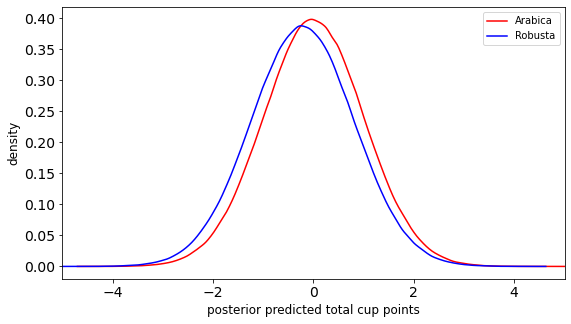

In [9]:
samples = trace_sp.posterior
cp1 = np.random.normal(samples.alpha[:,:,0], samples.sigma, size=(200,4,1000))
cp2 = np.random.normal(samples.alpha[:,:,1], samples.sigma, size=(200,4,1000))

fig, ax = plt.subplots(figsize=(9,5))
ax.set_xlabel("posterior predicted total cup points",fontsize=12)
ax.set_ylabel("density",fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)
az.plot_dist(cp1, ax = ax, color='r',label='Arabica')
az.plot_dist(cp2, ax = ax, color='b', label='Robusta')
ax.set_xlim(-5,5)

Use backdoor criterion and estimate both the **total effect** and **direct effect** of $AR$ on $CP$.

In [10]:
#First,look at the total effect of AR on CP


$$
\begin{align*} CP_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha + \beta AR_i  
\\
\alpha_j &\sim \text{Normal}(0, 0.2)
\\
\color{black}{\beta \ } &\color{black}{\sim \text{Normal}(0,0.5)}
\\
\sigma &\sim \text{Exponential}(1) \end{align*}$$

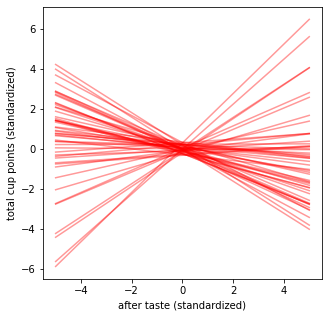

In [11]:
#Prior Predictive Analysis
with pm.Model() as model_art:
    alpha = pm.Normal('alpha', mu = 0, sigma = 0.2)
    beta = pm.Normal('beta', mu = 0, sigma = 0.5)
    sigma = pm.Exponential('sigma',1)
    prior_pred_model_art = pm.sample_prior_predictive()
    
Aseq = np.linspace(-5, 5, 30)
fig, ax = plt.subplots(figsize=(5,5))
for i in range(50):
    y = prior_pred_model_art['alpha'][i,] + prior_pred_model_art['beta'][i,] * Aseq
    ax.plot(Aseq, y, "r", alpha = 0.4) 
    ax.set_xlabel("after taste (standardized)")
    ax.set_ylabel("total cup points (standardized)")


In [12]:
#Model itself
with pm.Model() as model_art:
    alpha = pm.Normal('alpha', mu = 0, sigma = 0.2)
    beta = pm.Normal('beta', mu = 0, sigma = 0.5)
    sigma = pm.Exponential('sigma',1)
    mu = alpha + beta*dsimp.ar
    cp = pm.Normal('cp', mu = mu,  sigma = sigma, observed = dsimp.cp)
    trace_model_art = pm.sample(1000, tune = 1000, return_inferencedata=True)
      
   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [13]:
az.summary(trace_model_art, kind = "stats")    

,mean,sd,hdi_3%,hdi_97%
alpha,-0.001,0.029,-0.055,0.051
beta,0.729,0.029,0.674,0.784
sigma,0.684,0.020,0.648,0.723


In [14]:
az.summary(trace_model_art, kind = "diagnostics") 

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.0,0.0,4762.0,2643.0,1.0
beta,0.0,0.0,4739.0,2949.0,1.0
sigma,0.0,0.0,5706.0,3221.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

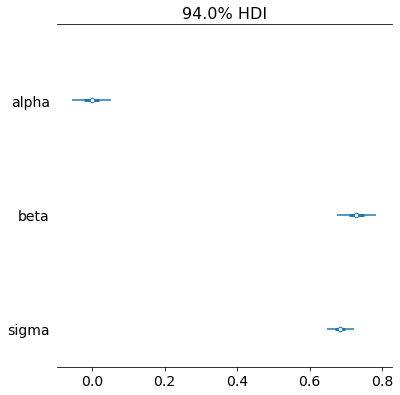

In [15]:
az.plot_forest(trace_model_art,combined=True)

In [16]:
#Secondly,direct effect of AR on CP.Therefore we should stratify AT.


$$
\begin{align*} CP_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha + \beta_r AR_i  +  \beta_t AT_i
\\
\alpha &\sim \text{Normal}(0, 0.2)
\\
\color{black}{\beta_r \ } &\color{black}{\sim \text{Normal}(0,0.5)}
\\
\color{black}{\beta_t \ } &\color{black}{\sim \text{Normal}(0,0.5)}
\\
\sigma &\sim \text{Exponential}(1) \end{align*}$$

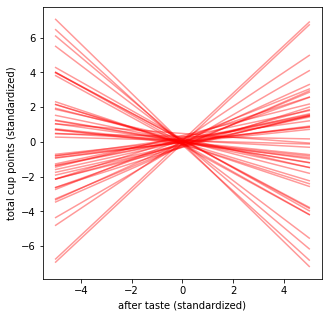

In [17]:
#Prior Predictive Analysis
with pm.Model() as model_ard:
    alpha = pm.Normal('alpha', mu = 0, sigma = 0.2)
    beta_r = pm.Normal('beta_r', mu = 0, sigma = 0.5)
    beta_t = pm.Normal('beta_t', mu = 0, sigma = 0.5)
    sigma = pm.Exponential('sigma',1)
    prior_pred_model_ard = pm.sample_prior_predictive()
    
Aseq = np.linspace(-5, 5, 30)
fig, ax = plt.subplots(figsize=(5,5))
for i in range(50):
    y = prior_pred_model_ard['alpha'][i,] + prior_pred_model_ard['beta_r'][i,] * Aseq + prior_pred_model_ard['beta_t'][i,] * Aseq
    ax.plot(Aseq, y, "r", alpha = 0.4) 
    ax.set_xlabel("after taste (standardized)")
    ax.set_ylabel("total cup points (standardized)")

    
    

In [18]:
#Model itself
with pm.Model() as model_ard:
    alpha = pm.Normal('alpha', mu = 0, sigma = 0.2)
    beta_r = pm.Normal('beta_r', mu = 0, sigma = 0.5)
    beta_t = pm.Normal('beta_t', mu = 0, sigma = 0.5)
    sigma = pm.Exponential('sigma',1)
    mu = alpha + beta_r * dsimp["ar"] + beta_t * dsimp["at"]

    cp = pm.Normal('cp', mu = mu,  sigma = sigma, observed = dsimp.cp)
    trace_model_ard = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_t, beta_r, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [19]:
az.summary(trace_model_ard, kind = "stats") 

,mean,sd,hdi_3%,hdi_97%
alpha,-0.001,0.021,-0.042,0.039
beta_r,0.231,0.031,0.172,0.291
beta_t,0.678,0.032,0.620,0.738
sigma,0.506,0.015,0.477,0.532


In [20]:
az.summary(trace_model_ard, kind = "diagnostics") 

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.0,3712.0,2717.0,1.0
beta_r,0.001,0.0,2965.0,2853.0,1.0
beta_t,0.001,0.0,3017.0,2681.0,1.0
sigma,0.000,0.0,3529.0,2926.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

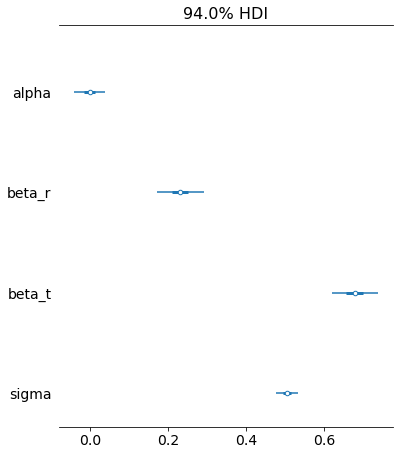

In [21]:
az.plot_forest(trace_model_ard,combined=True)



Estimate the **direct effect** of $AT$ on $CP$. 

In [22]:
#To estimate the direct effect of AT on CP, we should stratify AR according to backdoor criterion. 
#When we stratify AR, we have the same model as above.

In [23]:
with pm.Model() as model_atd:
    alpha = pm.Normal('alpha', mu = 0, sigma = 0.2)
    beta_r = pm.Normal('beta_r', mu = 0, sigma = 0.5)
    beta_t = pm.Normal('beta_t', mu = 0, sigma = 0.5)
    sigma = pm.Exponential('sigma',1)
    mu = alpha + beta_r * dsimp.ar + beta_t * dsimp["at"]

    cp = pm.Normal('cp', mu = mu,  sigma = sigma, observed = dsimp.cp)
    trace_model_atd = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_t, beta_r, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [24]:
az.summary(trace_model_atd, kind = "stats") 

,mean,sd,hdi_3%,hdi_97%
alpha,0.000,0.021,-0.041,0.039
beta_r,0.230,0.032,0.171,0.289
beta_t,0.679,0.032,0.615,0.735
sigma,0.505,0.015,0.478,0.534


In [25]:
az.summary(trace_model_atd, kind = "diagnostics") 

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.0,3836.0,2801.0,1.0
beta_r,0.001,0.0,2599.0,2512.0,1.0
beta_t,0.001,0.0,2548.0,2630.0,1.0
sigma,0.000,0.0,3518.0,2668.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

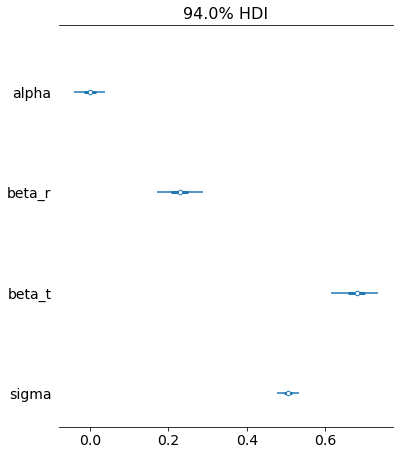

In [26]:
az.plot_forest(trace_model_atd,combined=True)

Based on the DAG, and your estimates above, discuss the effects of these measures on coffee quality.  

---

** When we look at the model 1,total effect of SP on CP, we see that average total cup points of Arabica is greater than the average total cup points of Robusta.
   When we look at the model 2, total effect of AR on CP, we see that aroma has a positive linear relation with total cup points since beta is positive. 
   When we look at the model 3,direct effect of AR and AT on CP, we can say that Aftertaste grade's direct effect is greater than Aroma grade's direct effect on total cup points since beta of AT is greater beta of AR.
 **

---

## Part 2 - Model Comparison

You must have three different models from the part above. Apart from those models, build a causal model where you stratify for all variables ($AR$, $SP$, $AT$). 

$$
\begin{align*} CP_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha_{s[i]} + \beta_{rs[i]} AR_i  +  \beta_{ts[i]} AT_i
\\
\alpha_j &\sim \text{Normal}(0, 0.2)
\\
\color{black}{\beta_{rj} \ } &\color{black}{\sim \text{Normal}(0,0.5)}
\\
\color{black}{\beta_{tj} \ } &\color{black}{\sim \text{Normal}(0,0.5)}
\\
\sigma &\sim \text{Exponential}(1) \end{align*}$$

In [27]:
with pm.Model() as model_all:
    alpha = pm.Normal('alpha', mu = 0, sigma = 0.2,shape = 2)
    beta_r = pm.Normal('beta_r', mu = 0, sigma = 0.5,shape = 2)
    beta_t = pm.Normal('beta_t', mu = 0, sigma = 0.5,shape = 2)
    sigma = pm.Exponential('sigma',1)
    mu = alpha[dsimp.sp] + beta_r[dsimp.sp] * dsimp.ar + beta_t[dsimp.sp] * dsimp["at"]

    cp = pm.Normal('cp', mu = mu,  sigma = sigma, observed = dsimp.cp)
    trace_model_all = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_t, beta_r, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [28]:
az.summary(trace_model_all, kind = "stats") 

,mean,sd,hdi_3%,hdi_97%
alpha[0],0.022,0.021,-0.016,0.063
alpha[1],-0.388,0.141,-0.649,-0.132
beta_r[0],0.225,0.031,0.171,0.286
beta_r[1],0.249,0.163,-0.058,0.552
beta_t[0],0.700,0.031,0.640,0.755
beta_t[1],0.206,0.191,-0.169,0.547
sigma,0.488,0.014,0.461,0.514


In [29]:
az.summary(trace_model_all, kind = "diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.000,0.000,4418.0,3197.0,1.0
alpha[1],0.002,0.002,4115.0,2851.0,1.0
beta_r[0],0.001,0.000,3793.0,3277.0,1.0
beta_r[1],0.003,0.002,4067.0,2987.0,1.0
beta_t[0],0.000,0.000,3924.0,3159.0,1.0
beta_t[1],0.003,0.002,3778.0,3001.0,1.0
sigma,0.000,0.000,4451.0,2933.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

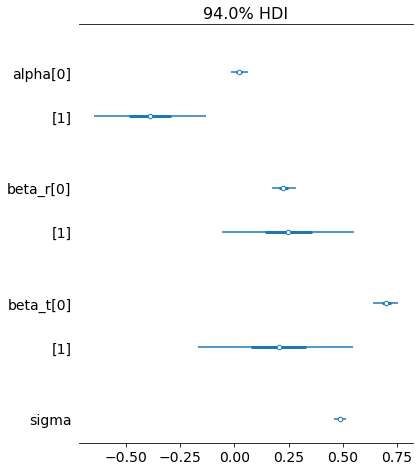

In [30]:
az.plot_forest(trace_model_all,combined=True)

Now compare the all four models (three from part 1 and the one above) using both PSIS and WAIC. Show all relevant statistics and diagrams to make this comparison, and discuss your results. Which model is expected make better predictions according to PSIS and WAIC? What does that tells us about the causal relations? 

In [31]:
compare_coffee_waic = az.compare({'$SP$':trace_sp, '$AR$':trace_model_art, '$AR + AT$':trace_model_ard, '$SP + AR + AT$':trace_model_all},
    scale="deviance",
    ic = "waic")
compare_coffee_waic

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
$SP + AR + AT$,0,819.256121,18.528456,0.000000,0.962409,115.047655,0.000000,True,deviance
$AR + AT$,1,855.659012,14.323966,36.402891,0.000000,109.035729,15.662975,True,deviance
$AR$,2,1198.635433,11.244274,379.379313,0.019485,102.099253,39.917573,True,deviance
$SP$,3,1627.122880,5.851358,807.866760,0.018106,74.358069,67.169466,True,deviance


<AxesSubplot:xlabel='Deviance'>

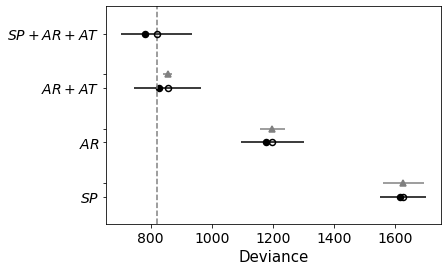

In [32]:
az.plot_compare(compare_coffee_waic)

In [33]:
compare_coffee_psis = az.compare({'$SP$':trace_sp, '$AR$':trace_model_art, '$AR + AT$':trace_model_ard, '$SP + AR + AT$':trace_model_all},
    scale="deviance",
    ic = "loo")
compare_coffee_psis

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-pac

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
$SP + AR + AT$,0,819.151277,18.476034,0.000000,9.623155e-01,114.793725,0.000000,True,deviance
$AR + AT$,1,855.066995,14.027958,35.915718,7.642159e-12,108.570589,15.743397,True,deviance
$AR$,2,1198.292749,11.072933,379.141472,1.956882e-02,101.822692,39.928469,True,deviance
$SP$,3,1627.038663,5.809249,807.887385,1.811564e-02,74.312196,66.992021,False,deviance


<AxesSubplot:xlabel='Deviance'>

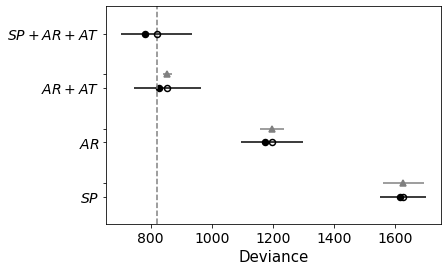

In [34]:
az.plot_compare(compare_coffee_psis)

**When we compare these four models, both PSIS and WAIC show that best causal model is where we stratify for all variables (AR, AT and SP) **

Do a robust regression on the best performing model, and compare them to each other using PSIS and WAIC. (15 pts)

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


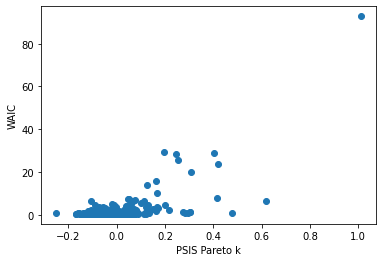

In [35]:
psis_m_all = az.loo(trace_model_all, pointwise=True, scale="deviance")
waic_m_all = az.waic(trace_model_all, pointwise=True, scale="deviance")


plt.scatter(psis_m_all.pareto_k, waic_m_all.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC");

In [36]:
#Robust regression
with pm.Model() as model_all_t:
    alpha = pm.Normal('alpha', mu = 0, sigma = 0.2,shape = 2)
    beta_r = pm.Normal('beta_r', mu = 0, sigma = 0.5,shape = 2)
    beta_t = pm.Normal('beta_t', mu = 0, sigma = 0.5,shape = 2)
    sigma = pm.Exponential('sigma',1)
    mu = alpha[dsimp.sp] + beta_r[dsimp.sp] * dsimp.ar + beta_t[dsimp.sp] * dsimp["at"]

    cp = pm.StudentT('cp', nu=2, mu = mu,  sigma = sigma, observed = dsimp.cp)
    trace_model_all_t = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_t, beta_r, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [37]:
compare_coffee_all_psis = az.compare({'$Normal$':trace_model_all, '$Student T$':trace_model_all_t},
    scale="deviance",
    ic = "loo")
compare_coffee_all_psis

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
$Student T$,0,404.517021,6.715558,0.000000,0.933028,62.232835,0.000000,False,deviance
$Normal$,1,819.151277,18.476034,414.634256,0.066972,114.793725,88.780239,True,deviance


In [38]:
compare_coffee_all_waic = az.compare({'$Normal$':trace_model_all, '$Student T$':trace_model_all_t},
    scale="deviance",
    ic = "waic")
compare_coffee_all_waic

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
$Student T$,0,404.392903,6.653499,0.000000,0.932934,62.233433,0.000000,False,deviance
$Normal$,1,819.256121,18.528456,414.863217,0.067066,115.047655,89.068003,True,deviance


In [ ]:
#As seen above in both Psis and Waic Robust regression(StudentT) is better than the Normal one. 
#Normal means here is the model where we have all AT,AR and SP.

## Part 3 - Expanded DAG 

Consider all the variables in [the coffee ratings dataset](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-07-07) and build a larger/more comprehensive DAG than the one above. You can draw this DAG below. 

<Axes:>

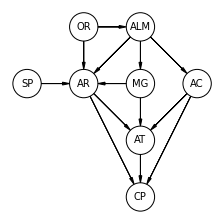

In [39]:
pgm = daft.PGM()
pgm.add_node("OR","OR",2,4)
pgm.add_node("AR","AR",2,3)
pgm.add_node("AT","AT",3,2)
pgm.add_node("CP","CP",3,1)
pgm.add_node("SP","SP",1,3)
pgm.add_node("ALM","ALM",3,4)
pgm.add_node("MG","MG",3,3)
pgm.add_node("AC","AC",4,3)

pgm.add_edge("SP", "AR")
pgm.add_edge("AR", "AT")
pgm.add_edge("AT", "CP")
pgm.add_edge("AR", "CP")
pgm.add_edge("OR", "AR")
pgm.add_edge("ALM", "MG")
pgm.add_edge("ALM", "AR")
pgm.add_edge("ALM", "AC")
pgm.add_edge("AC", "AT")
pgm.add_edge("MG", "AT")
pgm.add_edge("AC", "CP")
pgm.add_edge("MG", "AR")
pgm.add_edge("OR", "ALM")

pgm.render()

Describe this DAG (what kind of causal assumptions you made) in this DAG.

---

**In the DAG, R represents Region, SP represents Species, AR represents Aroma, ALM represents Altitude Mean Meters, MG represents Moisture Grade, AC represents Aciditiy Grade, AT represents Aftertaste Grade, CP represents Total Cup Points. Region and Species affect Aroma Grade. Altitude Mean affects Aroma Grade,Acidity Grade and Moisture Grade. Moisture Grade affects Aroma Grade and Aftertaste Grade. Aroma Grade affects Aftertaste Grade and Total Cup Points. Acidity Grade affects Aftertaste Grade and Total Cup Points. Aftertaste Grade affects Total Cup Points. Country of origin affects Altitude Mean **

---

## Bonus

Build a **full Bayes** model on this DAG (in which you model all the relations and present the posteriors of this model).


In [40]:
dfull = d[["farm_name", "total_cup_points", "aroma", "aftertaste", "species","country_of_origin", "acidity", "moisture", "altitude_mean_meters"]].groupby(by='farm_name').sample(n = 1)
dfull.head()

,farm_name,total_cup_points,aroma,aftertaste,species,country_of_origin,acidity,moisture,altitude_mean_meters
255,-,84.00,7.67,7.67,Arabica,Kenya,7.75,0.00,1650.0
1269,1,76.17,7.33,6.50,Arabica,Indonesia,6.08,0.12,3500.0
1307,200 farms,67.92,6.75,6.42,Arabica,Haiti,6.67,0.14,350.0
1297,2000 farmers,72.33,6.92,7.08,Arabica,Haiti,7.17,0.08,1020.0
1047,2000 farms,80.75,7.42,7.42,Arabica,Haiti,7.25,0.12,1000.0


In [41]:
#First,standardize the data
dfull["ar"]=(dfull.aroma-dfull.aroma.mean()) / dfull.aroma.std()
dfull["at"]=(dfull.aftertaste - dfull.aftertaste.mean()) / dfull.aftertaste.std()
dfull["cp"]=(dfull.total_cup_points-dfull.total_cup_points.mean())/dfull.total_cup_points.std()
dfull["mg"]=(dfull.moisture - dfull.moisture.mean()) / dfull.moisture.std()
dfull["ac"]=(dfull.acidity - dfull.acidity.mean()) / dfull.acidity.std()
dfull["alm"]=(dfull.altitude_mean_meters - dfull.altitude_mean_meters.mean()) / dfull.altitude_mean_meters.std()
#Create a column sp and or for changing species and country of origin into dummy variables
dfull["sp"]=dfull['species']
dfull['sp'] = pd.factorize(dfull['sp'])[0]
dfull["or"]=dfull['country_of_origin']
dfull["or"] = pd.factorize(dfull['country_of_origin'])[0]

dfull.at

In [42]:
with pm.Model() as model_full:
    #Aroma
    alpha_ar = pm.Normal('alpha_ar', mu = 0, sigma = 0.2, shape=[2,36])
    beta_ar1 = pm.Normal('beta_ar1', mu = 0, sigma = 0.5, shape=[2,36])
    beta_ar2 = pm.Normal('beta_ar2', mu = 0, sigma = 0.5, shape=[2,36])
    sigma_ar = pm.Uniform('sigma_ar',0 ,1)
    mu_ar = alpha_ar[dfull.sp, dfull["or"]] + beta_ar1[dfull.sp, dfull["or"]]*dfull["alm"] + beta_ar2[dfull.sp, dfull["or"]]*dfull.mg
    aroma_1 = pm.Normal('aroma1', mu= mu_ar, sigma=sigma_ar, observed = dfull.ar)
    
    #Altitude Mean Meters
    alpha_alm = pm.Normal('alpha_alm', mu = 0, sigma = 0.2, shape=36)
    mu_alm = alpha_alm[dfull["or"]] 
    sigma_alm = pm.Uniform('sigma_alm',0 ,1)
    altitude_mean = pm.Normal('altitude_mean',mu_alm, sigma=sigma_alm, observed = dfull["alm"])
    
    #Mouisture
    beta_mg = pm.Normal('beta_mg', mu = 0, sigma = 0.5)
    sigma_mg = pm.Uniform('sigma_mg',0 ,1)
    mu_mg = beta_mg*dfull["alm"]
    moisture_1 = pm.Normal('moisture_1', mu= mu_mg, sigma=sigma_mg, observed = dfull.mg)
    
    #Acidity 
    beta_ac = pm.Normal('beta_ac', mu = 0, sigma = 0.5)
    sigma_ac = pm.Uniform('sigma_ac',0 ,1)
    mu_ac = beta_ac*dfull["alm"]
    acidity_1 = pm.Normal('acidity_1', mu= mu_ac, sigma=sigma_ac, observed = dfull.ac)
    
    #Aftertaste
    beta_at1 = pm.Normal('beta_at1', mu = 0, sigma = 0.5)
    beta_at2 = pm.Normal('beta_at2', mu = 0, sigma = 0.5)
    beta_at3 = pm.Normal('beta_at3', mu = 0, sigma = 0.5)
    sigma_at = pm.Uniform('sigma_at',0 ,1)
    mu_at = beta_at1*dfull["ar"] + beta_at2*dfull["mg"] + beta_at3*dfull["ac"]
    aftertaste_1 = pm.Normal('aftertaste_1', mu= mu_at, sigma=sigma_at, observed = dfull["at"])
    
    #Total Cup Points
    
    beta_cp1 = pm.Normal('beta_cp1', mu = 0, sigma = 0.5)
    beta_cp2 = pm.Normal('beta_cp2', mu = 0, sigma = 0.5)
    beta_cp3 = pm.Normal('beta_cp3', mu = 0, sigma = 0.5)
    sigma_cp = pm.Uniform('sigma_cp',0 ,1)
    mu_cp = beta_cp1*dfull["ar"] + beta_cp2*dfull["at"] + beta_cp3*dfull["ac"]
    totalpo_1 = pm.Normal('totalpo_1', mu= mu_cp, sigma=sigma_cp, observed = dfull.cp)
    
    
    
    trace_model_full = pm.sample(1000, tune = 1000, return_inferencedata=True)
    
    #I got an error and I couldnt find the reason.


/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in altitude_mean contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'alpha_ar': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]]), 'beta_ar1': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]]), 'beta_ar2': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]]), 'sigma_ar_interval__': array(0.), 'alpha_alm': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), 'sigma_alm_interval__': array(0.), 'altitude_mean_missing': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), 'beta_mg': array(0.), 'sigma_mg_interval__': array(0.), 'beta_ac': array(0.), 'sigma_ac_interval__': array(0.), 'beta_at1': array(0.), 'beta_at2': array(0.), 'beta_at3': array(0.), 'sigma_at_interval__': array(0.), 'beta_cp1': array(0.), 'beta_cp2': array(0.), 'beta_cp3': array(0.), 'sigma_cp_interval__': array(0.)}

Initial evaluation results:
alpha_ar                   49.72
beta_ar1                  -16.26
beta_ar2                  -16.26
sigma_ar_interval__        -1.39
alpha_alm                  24.86
sigma_alm_interval__       -1.39
altitude_mean_missing       0.00
beta_mg                    -0.23
sigma_mg_interval__        -1.39
beta_ac                    -0.23
sigma_ac_interval__        -1.39
beta_at1                   -0.23
beta_at2                   -0.23
beta_at3                   -0.23
sigma_at_interval__        -1.39
beta_cp1                   -0.23
beta_cp2                   -0.23
beta_cp3                   -0.23
sigma_cp_interval__        -1.39
aroma1                       NaN
altitude_mean           -1198.93
moisture_1                   NaN
acidity_1                    NaN
aftertaste_1            -1268.93
totalpo_1               -1268.93
Name: Log-probability of test_point, dtype: float64